# LeNet-5 Fault Injection

This code implements fault injection testing on a quantized LeNet-5 convolutional neural network using PyTorch. The network is trained on the MNIST dataset, quantized to 8-bit integers, and systematically tested by flipping individual bits in its parameters. The testing framework allows both random bit flips across all layers and targeted testing of specific layers and bit positions, measuring how these faults impact the model's classification accuracy.

![framework](framework.png)

Python and PyTorch make it easy to modify neural network parameters during runtime testing. PyTorch directly exposes quantized weights through its API, while TensorFlow doesn't allow modifying weights after quantization. Using established ML frameworks like PyTorch also leverages years of development and testing by the community, saving time and avoiding common pitfalls that others have already solved.

PyTorch requires defining forward to specify data flow through network layers - it's called automatically when you run lenet(input). The code inherits from nn.Module for automatic gradient computation.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Lenet(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(1, 6, kernel_size=5)
        self.s2 = nn.MaxPool2d(kernel_size=2)
        self.c3 = nn.Conv2d(6, 16, kernel_size=5)
        self.s4 = nn.MaxPool2d(kernel_size=2)
        self.f5 = nn.Linear(16 * 5 * 5, 120)
        self.f6 = nn.Linear(120, 84)
        self.f7 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.c1(x)
        x = F.relu(x)
        x = self.s2(x)
        x = self.c3(x)
        x = F.relu(x)
        x = self.s4(x)
        x = torch.flatten(x, start_dim=1)
        x = self.f5(x)
        x = F.relu(x)
        x = self.f6(x)
        x = F.relu(x)
        x = self.f7(x)

        return x


lenet = Lenet()

This code sets up data loading for the MNIST dataset. `NUM_WORKERS` is set to optimize CPU usage (max 4 threads) and batch size is 64. The transforms prep images by:
- Converting to tensors
- Normalizing with MNIST's mean (0.1307) and std (0.3081) 
- Adding 2-pixel padding to match LeNet input size

The MNIST dataset is downloaded and split:
- Test set (standard split)
- Training set split into 80% train, 20% validation

`DataLoader` wraps these datasets to enable batch processing with specified workers. Training data is shuffled, validation/test aren't.

In [2]:
import os
import torchvision.transforms as T
import torchvision.datasets as datasets
from torch.utils.data import random_split, DataLoader

NUM_WORKERS = min(4, os.cpu_count())
BATCH_SIZE = 64

transform = T.Compose(
    [
        T.ToTensor(),
        T.Normalize((0.1307,), (0.3081,)),
        T.Pad(2),
    ]
)
train_set = datasets.MNIST("tmp/data", train=True, download=True, transform=transform)
test_set = datasets.MNIST("tmp/data", train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size

train_set, val_set = random_split(train_set, [train_size, val_size])

train_loader = DataLoader(train_set, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_set, BATCH_SIZE, num_workers=NUM_WORKERS)
exp_loader = DataLoader(test_set, BATCH_SIZE, num_workers=NUM_WORKERS)

This function evaluates model accuracy by running inference in evaluation mode (`model.eval()`), disabling gradients for efficiency, and calculating the percentage of correct predictions by comparing model outputs against target labels.

In [3]:
def calculate_accuracy(model: nn.Module, loader: DataLoader) -> float:
    model.eval()
    total = correct = 0

    with torch.no_grad():
        for input, target in loader:
            output = model(input)
            pred = torch.argmax(output, dim=1)
            total += target.size(0)
            correct += (pred == target).sum().item()

    return correct / total

Training loop running for 3 epochs using Adam optimizer with learning rate 0.01. Each iteration zeros gradients, runs forward pass through LeNet, calculates cross-entropy loss between predictions and targets, backpropagates gradients (loss.backward()), and updates model weights (optimizer.step()). Progress prints every 100 batches. Finally tests model accuracy on test set using previously defined calculate_accuracy function.

In [4]:
import torch.optim as optim

EPOCHS = 3
LEARNING_RATE = 0.01

optimizer = optim.Adam(lenet.parameters(), lr=LEARNING_RATE)

lenet.train()
for epoch in range(EPOCHS):
    for batch_idx, (input, target) in enumerate(train_loader):
        optimizer.zero_grad()

        flip_output = lenet(input)
        loss = F.cross_entropy(flip_output, target)

        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(
                f"[TRAINING] epoch={epoch + 1} batch={batch_idx} loss={loss.item():.2f}"
            )


print(f"[TESTING] accuracy={(100 * calculate_accuracy(lenet, exp_loader)):.2f}%")

[TRAINING] epoch=1 batch=0 loss=2.31
[TRAINING] epoch=1 batch=100 loss=0.27
[TRAINING] epoch=1 batch=200 loss=0.10
[TRAINING] epoch=1 batch=300 loss=0.28
[TRAINING] epoch=1 batch=400 loss=0.19
[TRAINING] epoch=1 batch=500 loss=0.11
[TRAINING] epoch=1 batch=600 loss=0.01
[TRAINING] epoch=1 batch=700 loss=0.06
[TRAINING] epoch=2 batch=0 loss=0.11
[TRAINING] epoch=2 batch=100 loss=0.09
[TRAINING] epoch=2 batch=200 loss=0.19
[TRAINING] epoch=2 batch=300 loss=0.07
[TRAINING] epoch=2 batch=400 loss=0.31
[TRAINING] epoch=2 batch=500 loss=0.19
[TRAINING] epoch=2 batch=600 loss=0.02
[TRAINING] epoch=2 batch=700 loss=0.04
[TRAINING] epoch=3 batch=0 loss=0.16
[TRAINING] epoch=3 batch=100 loss=0.06
[TRAINING] epoch=3 batch=200 loss=0.12
[TRAINING] epoch=3 batch=300 loss=0.01
[TRAINING] epoch=3 batch=400 loss=0.10
[TRAINING] epoch=3 batch=500 loss=0.20
[TRAINING] epoch=3 batch=600 loss=0.06
[TRAINING] epoch=3 batch=700 loss=0.06
[TESTING] accuracy=96.54%


Saves trained LeNet model's parameters (weights and biases) to a file named "lenet.pt" using PyTorch's save function.

In [5]:
LENET_PATH = "lenet.pt"

torch.save(lenet.state_dict(), LENET_PATH)

This code creates a quantization-ready version of LeNet by subclassing it. QLenet adds quantization (QuantStub) and dequantization (DeQuantStub) layers around the original network's forward pass. These stubs mark where PyTorch should convert between floating-point and quantized (8-bit integer) representations. The model loads weights from the previously saved LeNet using load_state_dict, with weights_only=True to ignore any saved optimizer state.

In [6]:
from torch.quantization import QuantStub, DeQuantStub


class QLenet(Lenet):
    def __init__(self):
        super().__init__()
        self.quant = QuantStub()
        self.dequant = DeQuantStub()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.quant(x)
        x = super().forward(x)
        x = self.dequant(x)

        return x


qlenet = QLenet()

qlenet.load_state_dict(torch.load(LENET_PATH, weights_only=True))

<All keys matched successfully>

This code configures quantization using Facebook's FBGEMM backend, prepares the model for quantization, then calibrates it by running validation data through the network to collect statistics about activation ranges. Finally, it converts the model to use quantized (8-bit) weights and tests its accuracy. The `inplace=True` parameter modifies the model directly instead of creating copies.

In [7]:
import torch.quantization as quantization

BACKEND = "fbgemm"

qlenet.qconfig = quantization.get_default_qconfig(BACKEND)
quantization.prepare(qlenet, inplace=True)

qlenet.eval()
with torch.no_grad():
    for batch_idx, (input, _) in enumerate(val_loader):
        qlenet(input)
        print(f"[CALIBRATING] batch={batch_idx}")

quantization.convert(qlenet, inplace=True)

quant_accuracy = 100 * calculate_accuracy(qlenet, exp_loader)
print(f"[TESTING] accuracy={quant_accuracy:.2f}%")

/root/lenet/.venv/lib/python3.11/site-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


[CALIBRATING] batch=0
[CALIBRATING] batch=1
[CALIBRATING] batch=2
[CALIBRATING] batch=3
[CALIBRATING] batch=4
[CALIBRATING] batch=5
[CALIBRATING] batch=6
[CALIBRATING] batch=7
[CALIBRATING] batch=8
[CALIBRATING] batch=9
[CALIBRATING] batch=10
[CALIBRATING] batch=11
[CALIBRATING] batch=12
[CALIBRATING] batch=13
[CALIBRATING] batch=14
[CALIBRATING] batch=15
[CALIBRATING] batch=16
[CALIBRATING] batch=17
[CALIBRATING] batch=18
[CALIBRATING] batch=19
[CALIBRATING] batch=20
[CALIBRATING] batch=21
[CALIBRATING] batch=22
[CALIBRATING] batch=23
[CALIBRATING] batch=24
[CALIBRATING] batch=25
[CALIBRATING] batch=26
[CALIBRATING] batch=27
[CALIBRATING] batch=28
[CALIBRATING] batch=29
[CALIBRATING] batch=30
[CALIBRATING] batch=31
[CALIBRATING] batch=32
[CALIBRATING] batch=33
[CALIBRATING] batch=34
[CALIBRATING] batch=35
[CALIBRATING] batch=36
[CALIBRATING] batch=37
[CALIBRATING] batch=38
[CALIBRATING] batch=39
[CALIBRATING] batch=40
[CALIBRATING] batch=41
[CALIBRATING] batch=42
[CALIBRATING] batch=4

Saves the quantized LeNet model's state dictionary to "qlenet.pt" file, preserving the quantized weights and parameters.

In [8]:
QLENET_PATH = "qlenet.pt"

torch.save(qlenet.state_dict(), QLENET_PATH)

This code recreates a new quantization-ready LeNet (flenet), prepares and converts it for quantization without calibration, then loads the previously saved quantized weights from "qlenet.pt". This way the model starts directly with quantized weights instead of needing recalibration.

In [9]:
flenet = QLenet()

flenet.qconfig = quantization.get_default_qconfig(BACKEND)
quantization.prepare(flenet, inplace=True)
quantization.convert(flenet, inplace=True)

flenet.load_state_dict(torch.load(QLENET_PATH, weights_only=True))

/root/lenet/.venv/lib/python3.11/site-packages/torch/ao/quantization/observer.py:1315: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(
/root/lenet/.venv/lib/python3.11/site-packages/torch/_utils.py:413: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,


<All keys matched successfully>

These are utility functions for manipulating quantized model weights, including bit flipping, layer selection, tensor conversion, and quantization operations.

In [ ]:
from typing import Dict, Any, Tuple
import numpy as np
from torch import quantize_per_tensor
import random


def get_weight_key(model: nn.Module, attr: str) -> str:
    """Retrieves the appropriate weight key for accessing model parameters based on layer type.

    Args:
        model: Neural network module
        attr: Layer attribute name

    Returns:
        String key to access weights in state dict

    Raises:
        ValueError: If layer type is not supported (not Conv2d or Linear)
    """
    module = getattr(model, attr)
    if isinstance(module, torch.ao.nn.quantized.modules.conv.Conv2d):
        return f"{attr}.weight"
    elif isinstance(module, torch.ao.nn.quantized.modules.linear.Linear):
        return f"{attr}._packed_params._packed_params"
    raise ValueError(f"Unsupported module type: {type(module)}")


def get_bit(byte: np.int8, pos: int) -> np.int8:
    """Extracts the bit at specified position from an 8-bit integer.

    Args:
        byte: 8-bit integer input
        pos: Bit position to extract (0-7)

    Returns:
        Value of bit at specified position (0 or 1)
    """
    return np.bitwise_and(np.right_shift(byte, pos), np.int8(1))


def flip_bit(byte: np.int8, pos: int) -> np.int8:
    """Flips (inverts) the bit at specified position in an 8-bit integer.

    Args:
        byte: 8-bit integer input
        pos: Position of bit to flip (0-7)

    Returns:
        New 8-bit integer with specified bit flipped
    """
    return np.bitwise_xor(byte, np.left_shift(np.int8(1), pos))


# Tuple of suffixes used to identify weight parameters in state dict
WEIGHT_SUFFIXES = (".weight", "._packed_params._packed_params")


def randlayer(sd: Dict[str, Any]) -> torch.Tensor:
    """Randomly selects a layer from model state dictionary.

    Args:
        sd: Model state dictionary

    Returns:
        Key of randomly selected layer
    """
    layers = [k for k in sd.keys() if k.endswith(WEIGHT_SUFFIXES)]
    return random.choice(layers)


def clean_layer(layer: str) -> str:
    """Removes weight-related suffixes from layer name.

    Args:
        layer: Full layer name with suffix

    Returns:
        Clean layer name without suffix
    """
    for suffix in WEIGHT_SUFFIXES:
        layer = layer.removesuffix(suffix)
    return layer


def to_tensor(param) -> torch.Tensor:
    """Converts parameter to tensor if not already.

    Args:
        param: Model parameter (tensor or tuple)

    Returns:
        Parameter as tensor

    Raises:
        ValueError: If parameter type is not supported
    """
    if isinstance(param, torch.Tensor):
        return param
    elif isinstance(param, tuple) and len(param) > 0:
        return param[0]
    raise ValueError(f"Unsupported parameter type: {type(param)}")


def randidx(tensor: torch.Tensor) -> Tuple[int, ...]:
    """Generates random indices for each dimension of tensor.

    Args:
        tensor: Input tensor

    Returns:
        Tuple of random indices matching tensor dimensions
    """
    return tuple(random.randint(0, s - 1) for s in tensor.shape)


def randbitpos() -> int:
    """Generates random bit position (0-7) for 8-bit integer.

    Returns:
        Random integer between 0 and 7
    """
    return random.randint(0, 7)


def dequant_int8(val: np.int8, scale: float, zero_point: int) -> float:
    """Dequantizes 8-bit integer to floating point value.

    Args:
        val: Quantized 8-bit value
        scale: Quantization scale factor
        zero_point: Quantization zero point

    Returns:
        Dequantized floating point value
    """
    return float(val - zero_point) * scale


def quant_to_int8(tensor: torch.Tensor) -> np.int8:
    """Converts quantized tensor to 8-bit integer representation.

    Args:
        tensor: Quantized input tensor

    Returns:
        NumPy array of 8-bit integers
    """
    return tensor.int_repr().numpy().astype(np.int8)


def int8_to_quant(input: np.int8, scale: float, zero_point: int) -> torch.Tensor:
    """Converts 8-bit integer to quantized tensor.

    Args:
        input: 8-bit integer input
        scale: Quantization scale factor
        zero_point: Quantization zero point

    Returns:
        Quantized tensor
    """
    return quantize_per_tensor(
        torch.tensor(dequant_int8(input, scale, zero_point), dtype=torch.float32),
        scale,
        zero_point,
        torch.qint8,
    )


def infer(input: torch.Tensor, model: nn.Module) -> torch.Tensor:
    """Performs inference using quantized model.

    Args:
        input: Input tensor
        model: Neural network model

    Returns:
        Model prediction (argmax of output)
    """
    model.eval()
    with torch.no_grad():
        return torch.argmax(model(input), dim=1)

Creates a DataLoader for test dataset with specified batch size and number of worker threads for parallel data loading.

In [11]:
exp_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

This code performs fault injection testing on a quantized neural network by iterating through test data, randomly selecting and flipping bits in model parameters, and recording the impact on model outputs. For each input image, it creates a copy of the model's state, randomly selects a layer and parameter, flips a random bit in that parameter, runs inference with the modified model, and stores the results (including layer information, bit positions, original and flipped parameter values, and model outputs) in a DataFrame that's ultimately saved to a CSV file. After each test, it restores the model to its original state before proceeding to the next input.

In [18]:
import copy
import pandas as pd

NUM_EXPERIMENTS = 10

# Initialize empty results list and get original model state
results_rand = []
orig_sd = flenet.state_dict()

for _ in range(NUM_EXPERIMENTS):
    # Iterate through test data batches
    for inputs, targets in exp_loader:
        # Process each input image and target
        for input, target in zip(inputs, targets):
            input = input.unsqueeze(0)  # Add batch dimension
            output = infer(input, flenet)  # Get original model prediction

            sd = copy.deepcopy(orig_sd)  # Create copy of model state

            # Randomly select layer and parameter to modify
            layer = randlayer(sd)
            params = to_tensor(sd[layer])
            idx = randidx(params)  # Get random parameter index
            param = params[idx]  # Get parameter at index

            orig_param = quant_to_int8(param)  # Convert to 8-bit int

            # Select random bit and get original value
            bit_pos = randbitpos()
            orig_bit = get_bit(orig_param, bit_pos)
            flipped_bit = 1 if orig_bit == 0 else 0

            # Create parameter with flipped bit
            flipped_param = flip_bit(orig_param, bit_pos)

            # Convert back to quantized tensor and update model
            params[idx] = int8_to_quant(
                flipped_param, param.q_scale(), param.q_zero_point()
            )

            flenet.load_state_dict(sd)  # Load modified state

            flip_output = infer(input, flenet)  # Get prediction with flipped bit

            # Store results of this test
            results_rand.append(
                {
                    "layer": clean_layer(layer),
                    "bit_position": bit_pos,
                    "original_bit": orig_bit,
                    "flipped_bit": flipped_bit,
                    "original_param": orig_param,
                    "flipped_param": flipped_param,
                    "original_output": output.item(),
                    "flipped_output": flip_output.item(),
                    "target_output": target.item(),
                }
            )

            flenet.load_state_dict(orig_sd)  # Restore original state

# Convert results to DataFrame and save
df_rand = pd.DataFrame(results_rand)
df_rand.to_csv("results.csv", index=False)

This line filters the DataFrame to show only cases where flipping a bit changed the model's output (where original and flipped predictions differ), creating a subset of errors caused by bit flips.

In [19]:
rand_errors_df = df_rand[df_rand["original_output"] != df_rand["flipped_output"]]

rand_errors_df

,layer,bit_position,original_bit,flipped_bit,original_param,flipped_param,original_output,flipped_output,target_output
926,c1,7,1,0,-44,84,2,0,2
1044,c1,0,1,0,-9,-10,6,0,6
1319,c1,7,0,1,10,-118,0,8,8
1462,c1,7,1,0,-21,107,2,3,2
1626,c1,7,0,1,30,-98,6,5,6
...,...,...,...,...,...,...,...,...,...
96124,c1,6,1,0,-30,-94,9,3,9
97020,f6,5,0,1,30,62,6,5,6
97151,c1,4,0,1,-20,-4,2,7,2
98332,c1,3,0,1,-128,-120,7,9,9


([0, 1, 2, 3, 4],
 [Text(0, 0, 'c1'),
  Text(1, 0, 'c3'),
  Text(2, 0, 'f5'),
  Text(3, 0, 'f6'),
  Text(4, 0, 'f7')])

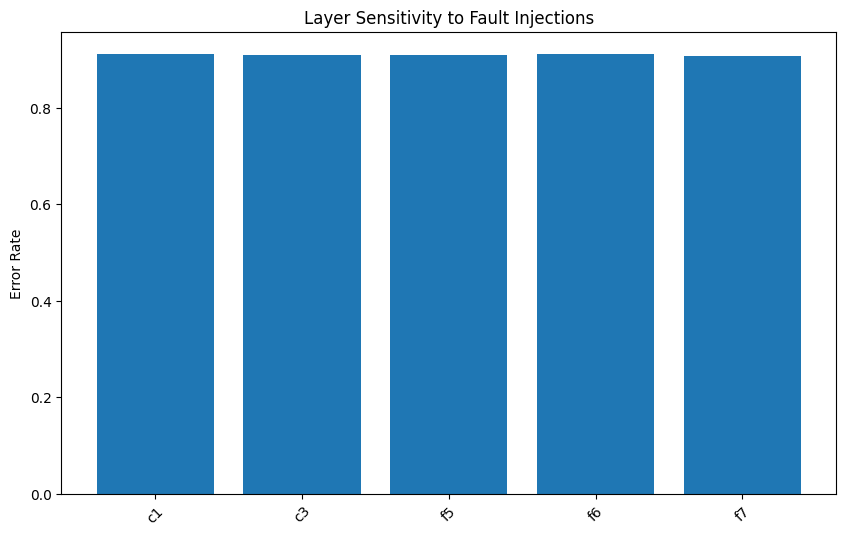

In [27]:
from matplotlib import pyplot as plt

# Layer sensitivity analysis
layer_stats = (
    df_rand.groupby("layer")
    .agg(
        {
            "flipped_output": lambda x: (
                x != x.shift()
            ).sum(),  # Count changes in output
            "original_output": "count",  # Total flips per layer
        }
    )
    .rename(columns={"flipped_output": "errors", "original_output": "total"})
)

layer_stats["error_rate"] = layer_stats["errors"] / layer_stats["total"]

plt.figure(figsize=(10, 6))
plt.bar(layer_stats.index, layer_stats["error_rate"])
plt.title("Layer Sensitivity to Fault Injections")
plt.ylabel("Error Rate")
plt.xticks(rotation=45)

/tmp/ipykernel_53187/3182270301.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bit_stats = df_rand.groupby("bit_position").apply(


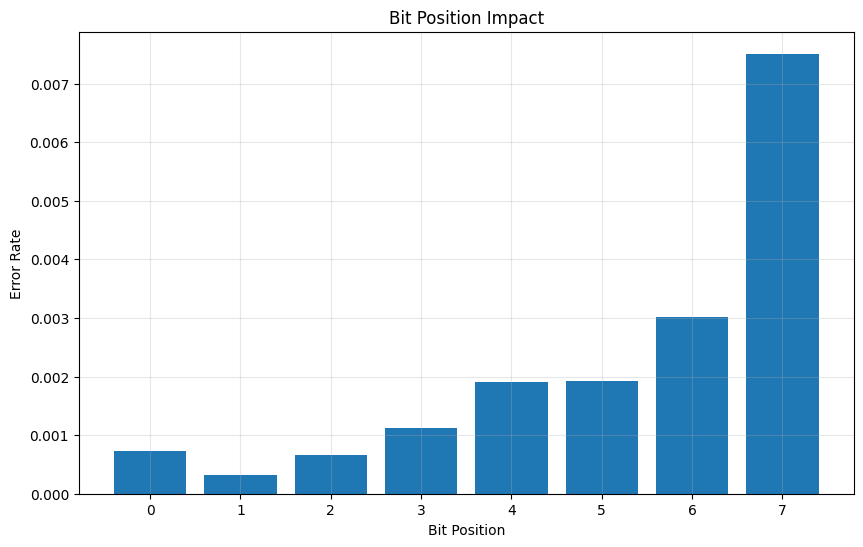

In [28]:
# Bit position impact
bit_stats = df_rand.groupby("bit_position").apply(
   lambda x: (x["original_output"] != x["flipped_output"]).mean()
).reset_index(name="error_rate")

plt.figure(figsize=(10, 6))
plt.bar(bit_stats["bit_position"], bit_stats["error_rate"])
plt.title("Bit Position Impact")
plt.xlabel("Bit Position")
plt.ylabel("Error Rate")
plt.grid(True, alpha=0.3)

/tmp/ipykernel_53187/3717712112.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x["original_output"] != x["flipped_output"]).mean())


Text(0, 0.5, 'Error Rate')

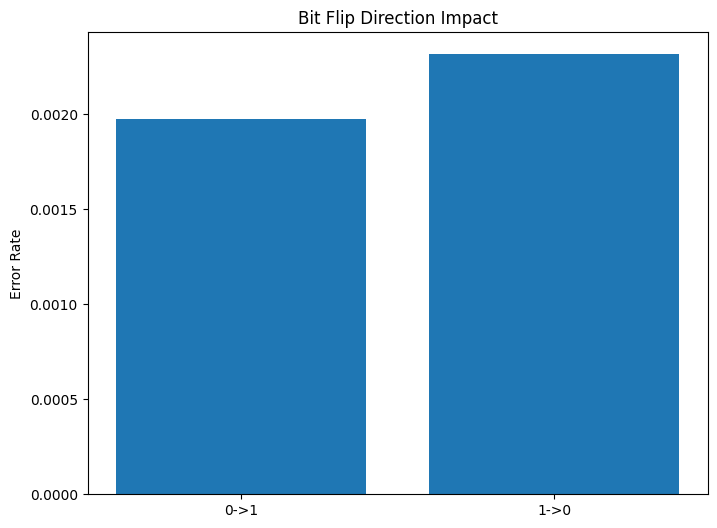

In [29]:
# Bit flip direction analysis
flip_stats = (
    df_rand.groupby(["original_bit", "flipped_bit"])
    .apply(lambda x: (x["original_output"] != x["flipped_output"]).mean())
    .reset_index(name="error_rate")
)

plt.figure(figsize=(8, 6))
plt.bar(
    [
        f"{o}->{f}"
        for o, f in zip(flip_stats["original_bit"], flip_stats["flipped_bit"])
    ],
    flip_stats["error_rate"],
)
plt.title("Bit Flip Direction Impact")
plt.ylabel("Error Rate")

This code performs the same bit-flip testing as before, but instead of randomly selecting layer and bit position, it specifically targets bit position 5 in the first convolutional layer (c1) of the network, allowing for focused analysis of faults in a specific network location.

In [ ]:
import copy
import pandas as pd

TARGET_LAYER = "c1"
TARGET_BIT_POS = 5

results_c1_5 = []
orig_sd = flenet.state_dict()

for inputs, targets in exp_loader:
    for input, target in zip(inputs, targets):
        input = input.unsqueeze(0)
        output = infer(input, flenet)

        sd = copy.deepcopy(orig_sd)

        layer = get_weight_key(flenet, TARGET_LAYER)
        params = to_tensor(sd[layer])
        idx = randidx(params)
        param = params[idx]

        orig_param = quant_to_int8(param)

        bit_pos = TARGET_BIT_POS
        orig_bit = get_bit(orig_param, bit_pos)
        flipped_bit = 1 if orig_bit == 0 else 0

        flipped_param = flip_bit(orig_param, bit_pos)

        params[idx] = int8_to_quant(
            flipped_param, param.q_scale(), param.q_zero_point()
        )

        flenet.load_state_dict(sd)

        flip_output = infer(input, flenet)

        results_c1_5.append(
            {
                "layer": clean_layer(layer),
                "bit_position": bit_pos,
                "original_bit": orig_bit,
                "flipped_bit": flipped_bit,
                "original_param": orig_param,
                "flipped_param": flipped_param,
                "original_output": output.item(),
                "flipped_output": flip_output.item(),
                "target_output": target.item(),
            }
        )

        flenet.load_state_dict(orig_sd)

df_c1_5 = pd.DataFrame(results_c1_5)
df_c1_5.to_csv("results_c1_5.csv", index=False)

In [15]:
c1_5_errors_df = df_c1_5[df_c1_5["original_output"] != df_c1_5["flipped_output"]]

c1_5_errors_df

,layer,bit_position,original_bit,flipped_bit,original_param,flipped_param,original_output,flipped_output,target_output
1,c1,5,1,0,-11,-43,1,2,2
125,c1,5,1,0,-11,-43,4,9,9
193,c1,5,1,0,-67,-99,8,9,9
247,c1,5,0,1,-127,-95,2,6,4
447,c1,5,0,1,26,58,1,4,4
...,...,...,...,...,...,...,...,...,...
9161,c1,5,1,0,-21,-53,8,5,8
9627,c1,5,0,1,-37,-5,5,6,6
9669,c1,5,0,1,-53,-21,7,1,4
9679,c1,5,1,0,-20,-52,3,5,6
